# xiaolei.chain document

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from corrLib import readseq
import numpy as np

## Characterization

### average cosine of bond angles
<code>avg_cos(traj, order_pNo)</code><br><br>
Calculate average cos's of adjacent particles (of a chain of particles) for a trajectory.
* traj: trajectory, a pd.DataFrame that contains columns (x, y, particle, frame)
* order_pNo: particle numbers in order, should be a list-like array

Returns:
* A pd.DataFrame containing columns (frame, cos)

In [3]:
from xiaolei.chain.characterize import avg_cos

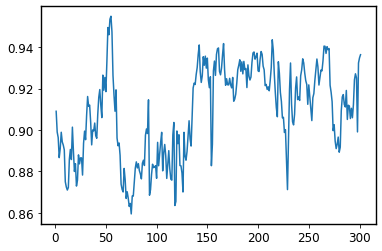

In [4]:
traj = pd.read_csv(r'I:\Github\Python\mylib\xiaolei\chain\test_files\data.csv')
order_pNo = [0, 13, 12, 11, 9, 8, 6, 7, 1, 2, 4, 3, 5, 14, 10]
df = avg_cos(traj, order_pNo)
plt.plot(df.frame, df.cos)

### Extract bond angle and arc length from particle tracking result
<code>get_angle_and_arc(traj, order_pNo)</code><br><br>
* traj: trajectory, a pd.DataFrame that contains columns (x, y, particle, frame)
* order_pNo: particle numbers in order, should be a list-like array

Returns:
* A pd.DataFrame containing columns (s, theta, frame), where s is arc length, theta is bond angle and frame is frame number

In [5]:
from xiaolei.chain.characterize import get_angle_and_arc
traj = pd.read_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\tracking1.csv')
order_pNo = np.array([0,1,2,3,4,5,6])
aaa = get_angle_and_arc(traj, order_pNo)
aaa.head()

,s,theta,frame
0,33.459280,-0.279700,2
1,67.393147,-0.518862,2
2,102.155065,-0.517483,2
3,134.460589,-0.495552,2
4,167.024936,-0.471336,2


### Calculate the Fourier coefficient of a set of arc lengths and bond angles (only for single frame)
<code>fourier_coef(data, n=10)</code><br><br>
* data: a pd.DataFrame containing columns (s, theta, frame), where s is arc length, theta is bond angle and frame is frame number (return value of function get_angle_and_arc, single frame)
* n: number of terms desired for the Fourier expansion

Return:
* An array of Fourier coefficients $a_1$...$a_n$

In [3]:
from xiaolei.chain.characterize import fourier_coef
data1 = pd.read_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\arc_and_angle.csv', index_col=0)
data = data1.loc[data1.frame==1]
coef = fourier_coef(data, n=12)
coef.head()

,n,a
0,1,-1.024852
1,2,1.846626
2,3,-0.359087
3,4,1.378536
4,5,-0.315412


### Calculate the Fourier coefficient for a video of a dynamic chain
<code>fourier_coef_video(data, n=10)</code><br><br>
This is a batch operation of function fourier_coef
* data: a pd.DataFrame containing columns (s, theta, frame), where s is arc length, theta is bond angle and frame is frame number (return value of function get_angle_and_arc)
* n: number of terms desired for the Fourier expansion

Return:
* A pd.DataFrame containing Fourier coefficients in all frames ('a', 'frame'). The index indicates the term number of coefficient in each frame.

In [4]:
from xiaolei.chain.characterize import fourier_coef_video
data = pd.read_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\arc_and_angle.csv', index_col=0)
data_all = fourier_coef_video(data, n=12)
data_all.head()

,n,a,frame
0,1,-1.024852,1
1,2,1.846626,1
2,3,-0.359087,1
3,4,1.378536,1
4,5,-0.315412,1


In [5]:
data_all.to_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\coef.csv')

### Calculate temporal variance
<code>temp_var(data, dt)</code><br><br>
* data: Fourier coefficient data pd.DataFrame containing columns ('a', 'frame'). Return value of function fourier_coef_video.
* dt: Time interval for the temporal change calculation. This is usually chosen to be a value larger than the relaxation time of the system (calculated from autocorrelation). Default to be 100.

Return:
* A pd.DataFram of temporal variances of coefficients for all modes var($a_n$). Containing columns ('n', 'var').

In [2]:
from xiaolei.chain.characterize import temp_var
dt = 100
data = pd.read_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\coef.csv', index_col=0)
varan = temp_var(data, dt)

Text(0, 0.5, 'Var(a$_n$)')

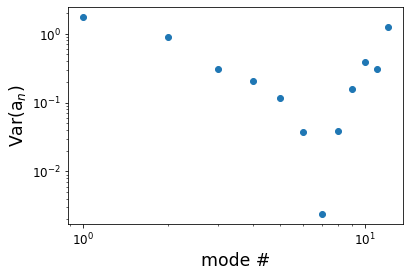

In [10]:
# Plot variance as a function of mode number
plt.plot(varan['n'], varan['var'], marker='o', ls='')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mode #')
plt.ylabel('Var(a$_n$)')

### Fit the var-mode plot to get $l_p$
<code>compute_lp(varan, L, nf=8)</code><br><br>
* varan: the temporal variance data, returned by function temp_var
* L: the contour length of the chain, L should be in a unit that is consistent with all previous calculations
* nf: number of modes to fit

Return:
* the persistence length of chain, the unit is consistent with the unit used for L in previous calculation

##### Math
<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
* Fit the first 6 points with power law
$$\text{var}(a_n) = \frac{L^2}{n^2\pi^2l_p}$$
$$l_p = \frac{L^2}{n^2\pi^2\text{var}(a_n)}$$
$$ \ln \text{var} =  \ln\frac{L^2}{\pi^2l_p} - 2\ln n$$
(refer to Biswal's paper)

In [3]:
from xiaolei.chain.characterize import compute_lp
varan = pd.read_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\varan.csv')
lp = compute_lp(varan, 230, nf=6)
lp

2181.5304396290467

## Particle tracking

### Particle tracking based on distance transform
<code>dt_track(folder, target_number, min_dist=20, radius=15, fitting_range=40, feature_size=7000, feature_number=1)</code><br><br>
Track chain partciles using masking and distance transform.
* folder: a folder directory containing an image sequence with extension _.tif_
* target_number: number of particles you aim to find
* min_dist：minimum distance allowed, one particle must not be too close to other particles, in order to be identified as a valid tracking.
* radius: radius of particle (px)
* fitting_range: fitting range for subpixel resolution fitting
* feature_size: whole chain size (px<sup>2</sup>)
* feature_number: number of chains you want to find (this might not be useful)
Returns:
* A pandas.DataFrame containing columns (x, y, Name), Name is the name of corresponding images

In [1]:
from xiaolei.chain.tracking import dt_track

In [3]:
folder = r'E:\Github\Python\mylib\xiaolei\chain\test_files'
traj = dt_track(folder, 15)
traj.head()

Processing frame 00000 ...
Processing frame 0008 ...
Processing frame 0019 ...
Processing frame 0035 ...
Processing frame 0086 ...
Processing frame 0299 ...


,x,y,Name
0,194.693477,69.999956,00000
7,411.542376,118.151009,00000
10,460.503098,209.401868,00000
9,441.714350,180.034502,00000
12,505.832036,241.105994,00000


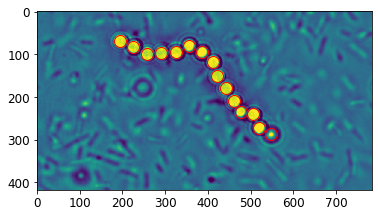

In [8]:
# Visualize the tracking result
l = readseq(folder)
for num, i in l.iterrows():
    if num > 0:
        break
    traj = traj.loc[traj.Name==i.Name]
    img = io.imread(i.Dir)
    plt.imshow(img)
    plt.plot(traj.x, traj.y, marker='o', markersize=12, ls='', mec='red', mfc=(0,0,0,0))